# Péndulo simple usando $\theta$ y mecánica lagrangiana
Juan Fernando Riascos y Thomas Martinod

Mecánica clásica 2024-1

In [286]:
# Importe de librerías
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False ## Usar True si se tiene LaTeX en el path


# Para hacer la animación del péndulo usando matplotlib
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

# Para imprimir las derivadas como \dot{x}
from sympy.physics.mechanics import *
init_vprinting(pretty_print=True)

Definimos la variable independiente $t$ y los parámetros del péndulo $g, m, l$.


In [287]:
# Creamos símbolos para t (tiempo), g (aceleración debido a la gravedad), m (masa) y l (longitud)
t, g, m, l = smp.symbols('t, g, m, l')

Definimos $\theta = \theta(t)$ como la variable del sistema dinámico.

In [288]:
# Definimos un símbolo para \phi como una función de t
phi = smp.symbols(r'\phi', cls=smp.Function)

# phi es función del tiempo
phi = phi(t)

Calculamos las primeras dos derivadas de phi $\dot{\phi}$ y $\ddot{\phi}$

In [289]:
# Calculamos la derivada de phi respecto a t (dphi)
dphi = smp.diff(phi, t)

# Calculamos la segunda derivada de phi respecto a t (d2phi)
d2phi = smp.diff(dphi, t)

Definimos además las variables $x, y$ en función de $\theta$

In [290]:
# Calculamos las coordenadas x e y en función de phi y l
x = l * smp.cos(phi)
y = l * smp.sin(phi)

# Calculamos las derivadas de x e y respecto a t (dx y dy)
dx = smp.diff(x, t)
dy = smp.diff(y, t)

Como vamos a usar mecánica lagrangiana, debemos hallar ${L} = T - V$.

Para ello, hallamos la energía cinética como: $T = \frac{1}{2} m ||\mathbf{v}||^2 = \frac{1}{2} m (\dot{x}^2 + \dot{y}^2)$

In [291]:
# Calculamos la energía cinética (T) en función de m, dx y dy
T = smp.Rational(1/2) * m * (dx**2 + dy**2)

Y para la energía potencial, ubicamos el 0 de esta en el valor máximo de $x$, es decir, cuando $x=l$.
Entonces $V = (l-x)mg$

In [292]:
# Calculamos la energía potencial (V) en función de m, g, l y x
V = (l - x) * m * g

El Lagrangiano es la diferencia de las anteriores: ${L} = T - V$

In [293]:
# Calculamos el lagrangiano (L) como la diferencia entre la energía cinética (T) y la energía potencial (V)
L = T - V

# Imprimimos el valor del lagrangiano (L)
L

El lagrangiano satisface la ecuación de Euler-Lagrange usando $\phi$ como coordenada generalizada.

En ausencia de torques (fuerzas) externas,
\begin{equation}
    \frac{\partial L}{\partial \phi} - \frac{d}{dt}\left(\frac{\partial L}{\partial \dot{\phi}}\right) = 0
\end{equation}

In [294]:
# Calculamos la ecuación de Euler-Lagrange (ELeq) para el péndulo
ELeq =  smp.Eq(smp.diff(L, phi) - smp.diff(smp.diff(L, dphi), t).simplify(), 0)

# Imprimimos la ecuación de Euler-Lagrange (ELeq)
ELeq

Solucionando esta ecuación diferencial para $\ddot{\theta}$, se obtiene:

In [295]:
# Resolvemos la ecuación de Euler-Lagrange (ELeq) para obtener d2phi
sln = smp.solve([ELeq], (d2phi))

# Imprimimos la solución (sln) para d2phi
sln

Es decir, se obtuvo la EDO $\ddot{\theta} = -\frac{g}{l}\sin{\theta}$

En general, se obtuvo:
* $\frac{d^2 \theta}{dt^2} = ...$

Esta es una EDO de segundo orden. En Python sólo podemos resolver sistemas de EDOs de primer orden. Cualquier EDO de segundo orden se puede convertir en un sistema de EDOS de 1er orden así:

1. Se define $z = d\theta/dt$
2. Entonces $dz/dt = d^2\theta/dt^2$

Ahora tenemos un sistema de 2 EDOs de primer orden (a diferencia de 2 de segundo orden)

* $d z/dt = ...$
* $d\theta/dt = z$

Necesitamos convertir las expresiones **simbólicas** anteriores a **funciones numéricas** para poder usarlas en un solucionador numérico de Python. Para esto, usamos `smp.lambdify`

In [296]:
# Definimos funciones para evaluar las derivadas de z y dphi en términos de t, g, m, l, phi y dphi
dzdt_f = smp.lambdify((t, g, m, l, phi, dphi), sln[d2phi])
dphidt_f = smp.lambdify(dphi, dphi)

Definimos $\vec{S} = (\theta, z)$. Si vamos a usar un `odeint` (solucionador de EDOs en Python), necesitamos escribir una función que tome $\vec{S}$ y $t$ y devuelva $d\vec{S}/dt$. En otras palabras, necesitamos definir $d\vec{S}/dt (\vec{S}, t)$.

Nuestro sistema de EDOs puede ser completamente especificado usando $d\vec{S}/dt$ y depende únicamente de $\vec{S}$ y $t$

In [297]:
def dSdt(S, t, g, m, l):
    # Descomponemos el vector S en las variables phi y z
    phi, z = S

    # Calculamos las derivadas de phi y z respecto a t usando las funciones definidas anteriormente
    dphi_dt = dphidt_f(z)
    dz_dt = dzdt_f(t, g, m, l, phi, z)

    # Devolvemos las derivadas como una lista
    return [dphi_dt, dz_dt]

Resolvemos numéricamente mediante `odeint` de scipy, especificando los parámetros y las condiciones iniciales.

In [298]:
# Definimos el tiempo entre 0 y 10 segundos con 500 fotogramas
t = np.linspace(0, 10, 501)

# Establecemos los valores de gravedad, masa y longitud
g_n = 9.81
m_n = 3
l_n = 2

# Definimos las condiciones iniciales [phi_0, dphi_0] en radianes y radianes por segundo
y_0 = [3, 0]

# Resolvemos la ecuación diferencial utilizando odeint
ans = odeint(dSdt, y0=y_0, t=t, args=(g_n, m_n, l_n))

Se grafica el ángulo $\theta$ con respecto al tiempo

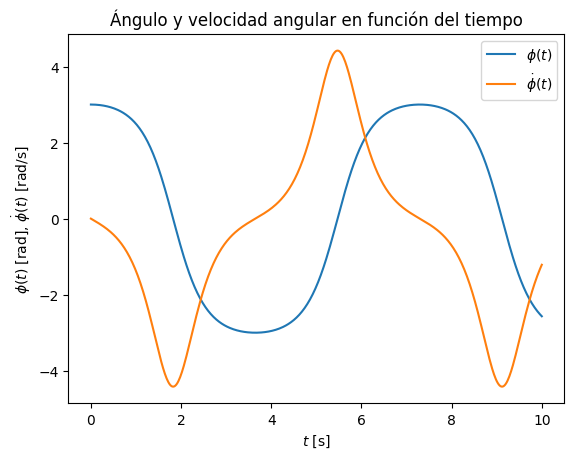

In [299]:
# Extraemos los valores de phi y la derivada de phi de la solución ans
phi_n = ans.T[0]
dphi_n = ans.T[1]

# Creamos una gráfica de phi y dphi en función del tiempo
plt.plot(t, phi_n, label=r'$\phi(t)$')  # Graficamos phi en función de t
plt.plot(t, dphi_n, label=r'$\dot{\phi}(t)$')  # Graficamos la derivada de phi en función de t

# Configuramos el título y etiquetas de los ejes con LaTeX
plt.title(r'Ángulo y velocidad angular en función del tiempo')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$\phi(t)$ [rad], $\dot{\phi}(t)$ [rad/s]')

# Agregamos una leyenda
plt.legend()

# Mostramos la gráfica
plt.show()

Se grafican $x$ y $y$ en función de $t$ (repetimos el proceso de graficación).

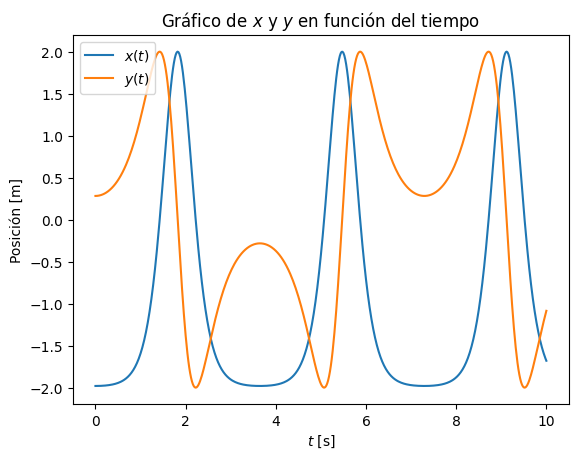

In [300]:
def get_xy(phi, l):
    return (l*np.cos(phi),
            l*np.sin(phi))


x_n, y_n = get_xy(ans.T[0], l_n)

plt.plot(t, x_n, label=r'$x(t)$')
plt.plot(t, y_n, label=r'$y(t)$')

plt.title(r'Gráfico de $x$ y $y$ en función del tiempo')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Posición [m]')
plt.legend()
plt.show()

Gráfico de las velocidades $\dot{x}, \dot{y}$ en el tiempo.

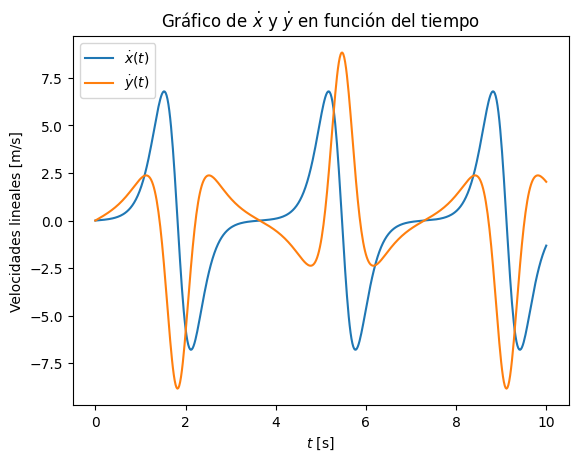

In [301]:
def get_dxdy(phi, dphi, l):
    return (-l*np.sin(phi)*dphi,
            l*np.cos(phi)*dphi)

dx_n, dy_n = get_dxdy(ans.T[0], ans.T[1], l_n)

plt.plot(t, dx_n, label=r'$\dot{x}(t)$')
plt.plot(t, dy_n, label=r'$\dot{y}(t)$')

plt.title(r'Gráfico de $\dot{x}$ y $\dot{y}$ en función del tiempo')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Velocidades lineales [m/s]')
plt.legend()
plt.show()

Graficación de $T, V, L, E = T+V$

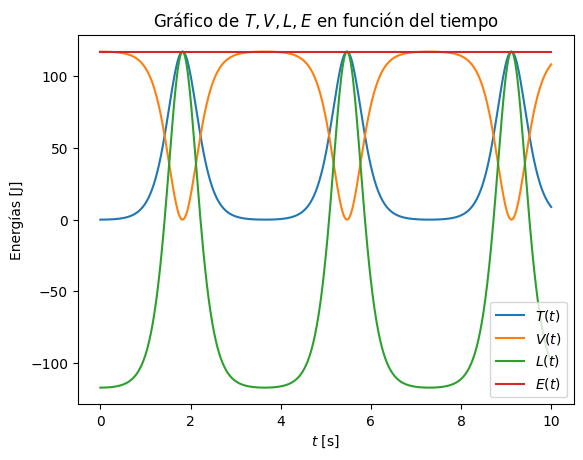

In [302]:
def get_TVL(m,g,x,y,dx,dy,l):
    T = m * (dx**2 + dy**2) / 2
    V = (l-x)*m*g
    L = T - V
    E = T + V
    return(T,V,L,E)

T_n, V_n, L_n, E_n = get_TVL(m_n, g_n, x_n, y_n, dx_n, dy_n,l_n)

plt.plot(t, T_n, label=r'$T(t)$')
plt.plot(t, V_n, label=r'$V(t)$')
plt.plot(t, L_n, label=r'$L(t)$')
plt.plot(t, E_n, label=r'$E(t)$')

plt.title(r'Gráfico de $T,V,L,E$ en función del tiempo')
plt.xlabel(r'$t$ [s]')
plt.ylabel('Energías [J]')
plt.legend()
plt.show()

Momentum

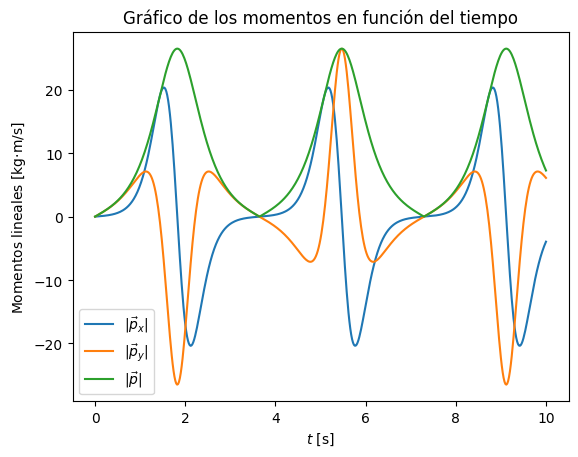

In [303]:
def get_p(m, dx, dy):
    px = m*dx
    py = m*dy
    p = np.sqrt(px**2 + py**2)
    return(px, py, p)

px_n, py_n, p_n = get_p(m_n, dx_n, dy_n)

plt.plot(t, px_n, label=r'$|\vec{p}_x|$')
plt.plot(t, py_n, label=r'$|\vec{p}_y|$')
plt.plot(t, p_n, label=r'$|\vec{p}|$')


plt.title('Gráfico de los momentos en función del tiempo')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'Momentos lineales [kg$\cdot$m/s]')
plt.legend()
plt.show()

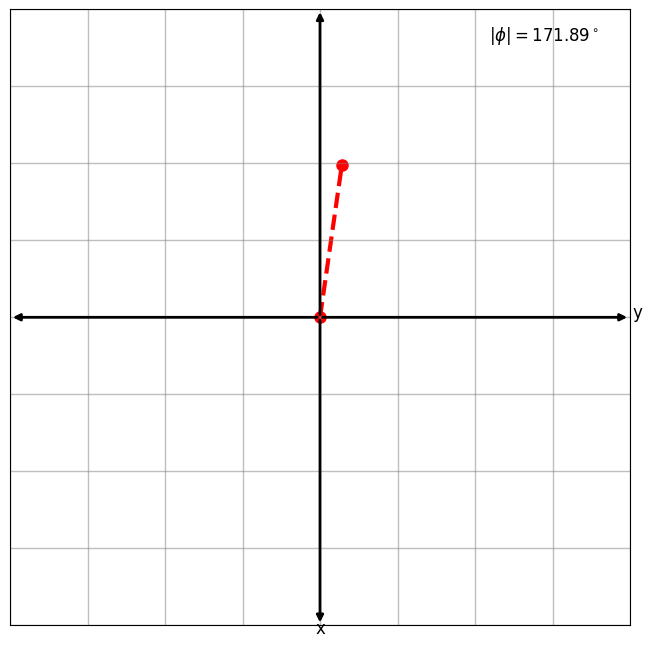

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Definir función para la animación
def animate(i):
    # Actualizar las posiciones de la línea en cada fotograma
    ln1.set_data([0, y_n[i]], [0, -x_n[i]])

    # Dibujar el trail del péndulo
    trail_length = 30  # Longitud del rastro
    if i >= trail_length:
        trail_indices = range(i - trail_length, i)
        trail_x = [y_n[j] for j in trail_indices]
        trail_y = [-x_n[j] for j in trail_indices]
        trail_segments.set_data(trail_x, trail_y)
    else:
        trail_segments.set_data([], [])

    # Calcular el ángulo entre el eje x hacia abajo y el péndulo
    angle_x_down = np.degrees(np.arccos(x_n[i] / l_n))

    # Actualizar el texto del ángulo en tiempo real
    angle_text.set_text(r'$|\phi| = {:.2f}^\circ$'.format(angle_x_down))

# Crear una figura y un eje
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Establecer el color de fondo del eje en blanco
ax.set_facecolor('white')

# Ocultar los ticks del eje x y del eje y
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# Crear una línea para el péndulo
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)

# Crear un conjunto de segmentos de línea para el trail del péndulo
trail_segments, = plt.plot([], [], color='black', lw=1, alpha=0.5)


# Agregar flechas a los extremos de las líneas de los ejes x e y
ax.annotate('', xy=(4, 0), xytext=(0, 0),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', linewidth=2))
ax.annotate('', xy=(-4, 0), xytext=(0, 0),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', linewidth=2))
ax.annotate('', xy=(0, 4), xytext=(0, 0),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', linewidth=2))
ax.annotate('', xy=(0, -4), xytext=(0, 0),
            arrowprops=dict(facecolor='black', arrowstyle='-|>', linewidth=2))

# Dibujar manualmente las líneas de la rejilla
for i in range(-4, 5):
    ax.plot([-4, 4], [i, i], color='gray', linestyle='-', linewidth=1, alpha=0.5)  # Líneas horizontales
    ax.plot([i, i], [-4, 4], color='gray', linestyle='-', linewidth=1, alpha=0.5)  # Líneas verticales


# Establecer los límites del eje x y del eje y
ax.set_ylim(-4, 4)
ax.set_xlim(-4, 4)

# Agregar texto para los ejes x e y
ax.text(4.1, 0, 'y', fontsize=12, ha='center')
ax.text(0, -4.1, 'x', fontsize=12, ha='center')

# Crear una anotación para mostrar el ángulo en tiempo real en la esquina superior derecha
angle_text = ax.text(0.95, 0.95, '', transform=ax.transAxes, ha='right', fontsize=12)

# Crear la animación con FuncAnimation
ani = animation.FuncAnimation(fig, animate, frames=250, interval=50)

# Guardar la animación como un archivo GIF
ani.save('pendulum_animation.gif', writer='pillow', fps=25)
